#  Мониторинг процесса обучения

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://mlflow.org/
* https://ngrok.com/
* https://mlflow.org/docs/latest/ml/getting-started/logging-first-model/
* https://mlflow.org/docs/latest/ml/deep-learning/pytorch/
* https://mlflow.org/docs/latest/ml/getting-started/logging-first-model/step6-logging-a-run/
* https://mlflow.org/docs/latest/ml/traditional-ml/tutorials/hyperparameter-tuning/part2-logging-plots/
* https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
* https://docs.wandb.ai/quickstart
* https://docs.wandb.ai/guides/track/log/log-summary#docusaurus_skipToContent_fallback
* https://docs.wandb.ai/guides/track/log/log-models

## Задачи для совместного разбора

In [42]:
# !pip install pyngrok
# !pip install mlflow
# !pip install playwright
# !playwright install

In [43]:
import mlflow

In [44]:
import subprocess
from IPython.display import IFrame

port = 5000
process = subprocess.Popen(["mlflow", "ui", "--port", str(port)])
print(f"MLflow UI запущен с PID (ID процесса): {process.pid}")
# IFrame(src=f"http://localhost:{port}/", width="100%", height=700)

MLflow UI запущен с PID (ID процесса): 6700


In [45]:
mlflow.set_tracking_uri("http://localhost:5000")

1\. Рассмотрите возможности пакета `mlflow` по отслеживанию числовых значений, визуализации изображений, таблиц и других артефактов.

## Задачи для самостоятельного решения

In [46]:
# !pip install playwright
# !playwright install

In [47]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import mlflow.pytorch
from IPython.display import HTML,Image, display
import time
import asyncio
from playwright.sync_api import sync_playwright
import sys
import threading

def run_screenshot_script(url, output_path):
    """
    Calls the external screenshot_script.py using a subprocess to avoid
    asyncio event loop conflicts within the notebook.
    """
    python_executable = sys.executable
    command = [python_executable, "screenshot_script.py", url, output_path]    
    result = subprocess.run(command, capture_output=True, text=True)
    
    if result.stderr:
        print("Error from screenshot script:\n", result.stderr)
    
    result.check_returncode()

<p class="task" id="1"></p>

1\. Решите задачу регрессии, используя для мониторинга процесса обучения `mlflow`. 

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики $R^2$ по эпохам. После завершения обучения рассчитайте значение метрик MSE, RMSE, MAE и MAPE и сохраните при помощи `log_metric`. Сохраните обученную модель при помощи `mlflow.pytorch.log_model`.

Обучите не менее трех моделей (с разной архитектурой или гиперпараметрами), отследите все запуски при помощи `mlflow` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` с графиками обучения. Для каждого запуска сохраняйте гиперпараметры модели и summary (страница overview).

- [ ] Проверено на семинаре

In [48]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlflow.set_tracking_uri("file:./mlruns") 
exp = mlflow.set_experiment("Sine Wave Regression")

In [49]:
def train_and_log_model(params):
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        experiment_id = run.info.experiment_id
        dset = TensorDataset(X_train,y_train)
        loader = DataLoader(dset, batch_size=params["batch_size"], shuffle=True)

        mlflow.log_params(params)

        model = nn.Sequential(
            nn.Linear(params["input_dim"], params["hidden_dim"]),
            nn.Tanh(),
            nn.Linear(params["hidden_dim"], params["output_dim"])
        )

        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"])

        for epoch in range(params["epochs"]):
            for X_batch, y_batch in loader:
                y_pred = model(X_batch).flatten()
                loss = criterion(y_pred, y_batch.flatten())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            mlflow.log_metric("train_loss", loss.item(), step=epoch)

            # model.eval()
            with torch.no_grad():
                test_pred = model(X_test)
                test_loss = criterion(test_pred, y_test)
                r2 = r2_score(y_test.numpy(), test_pred.numpy())
                mlflow.log_metric("test_loss", test_loss.item(), step=epoch)
                mlflow.log_metric("r2_score", r2, step=epoch)

        # print("Final metrics:")
        with torch.no_grad():
            final_preds = model(X_test)
            mse = mean_squared_error(y_test.numpy(), final_preds.numpy())
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test.numpy(), final_preds.numpy())
            mape = mean_absolute_percentage_error(y_test.numpy(), final_preds.numpy())
            metrics = {
                "final_mse": mse,
                "final_rmse": rmse,
                "final_mae": mae,
                "final_mape": mape
            }
            mlflow.log_metrics(metrics)
            # print(metrics)
            
        mlflow.pytorch.log_model(model, "model")
        mlflow.log_text(str(model), "model_summary.txt")
        
        run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}/model-metrics"
        screenshot_path = f"run_{run_url.split('/')[-1]}_metrics.png"
        
        try:
            run_screenshot_script(run_url, screenshot_path)
            display(Image(filename=screenshot_path))
        except Exception as e:
            print(f"Failed to generate or display the screenshot: {e}")

        return run_url

2025/10/07 23:24:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 23:24:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/07 23:24:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/07 23:24:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter whe

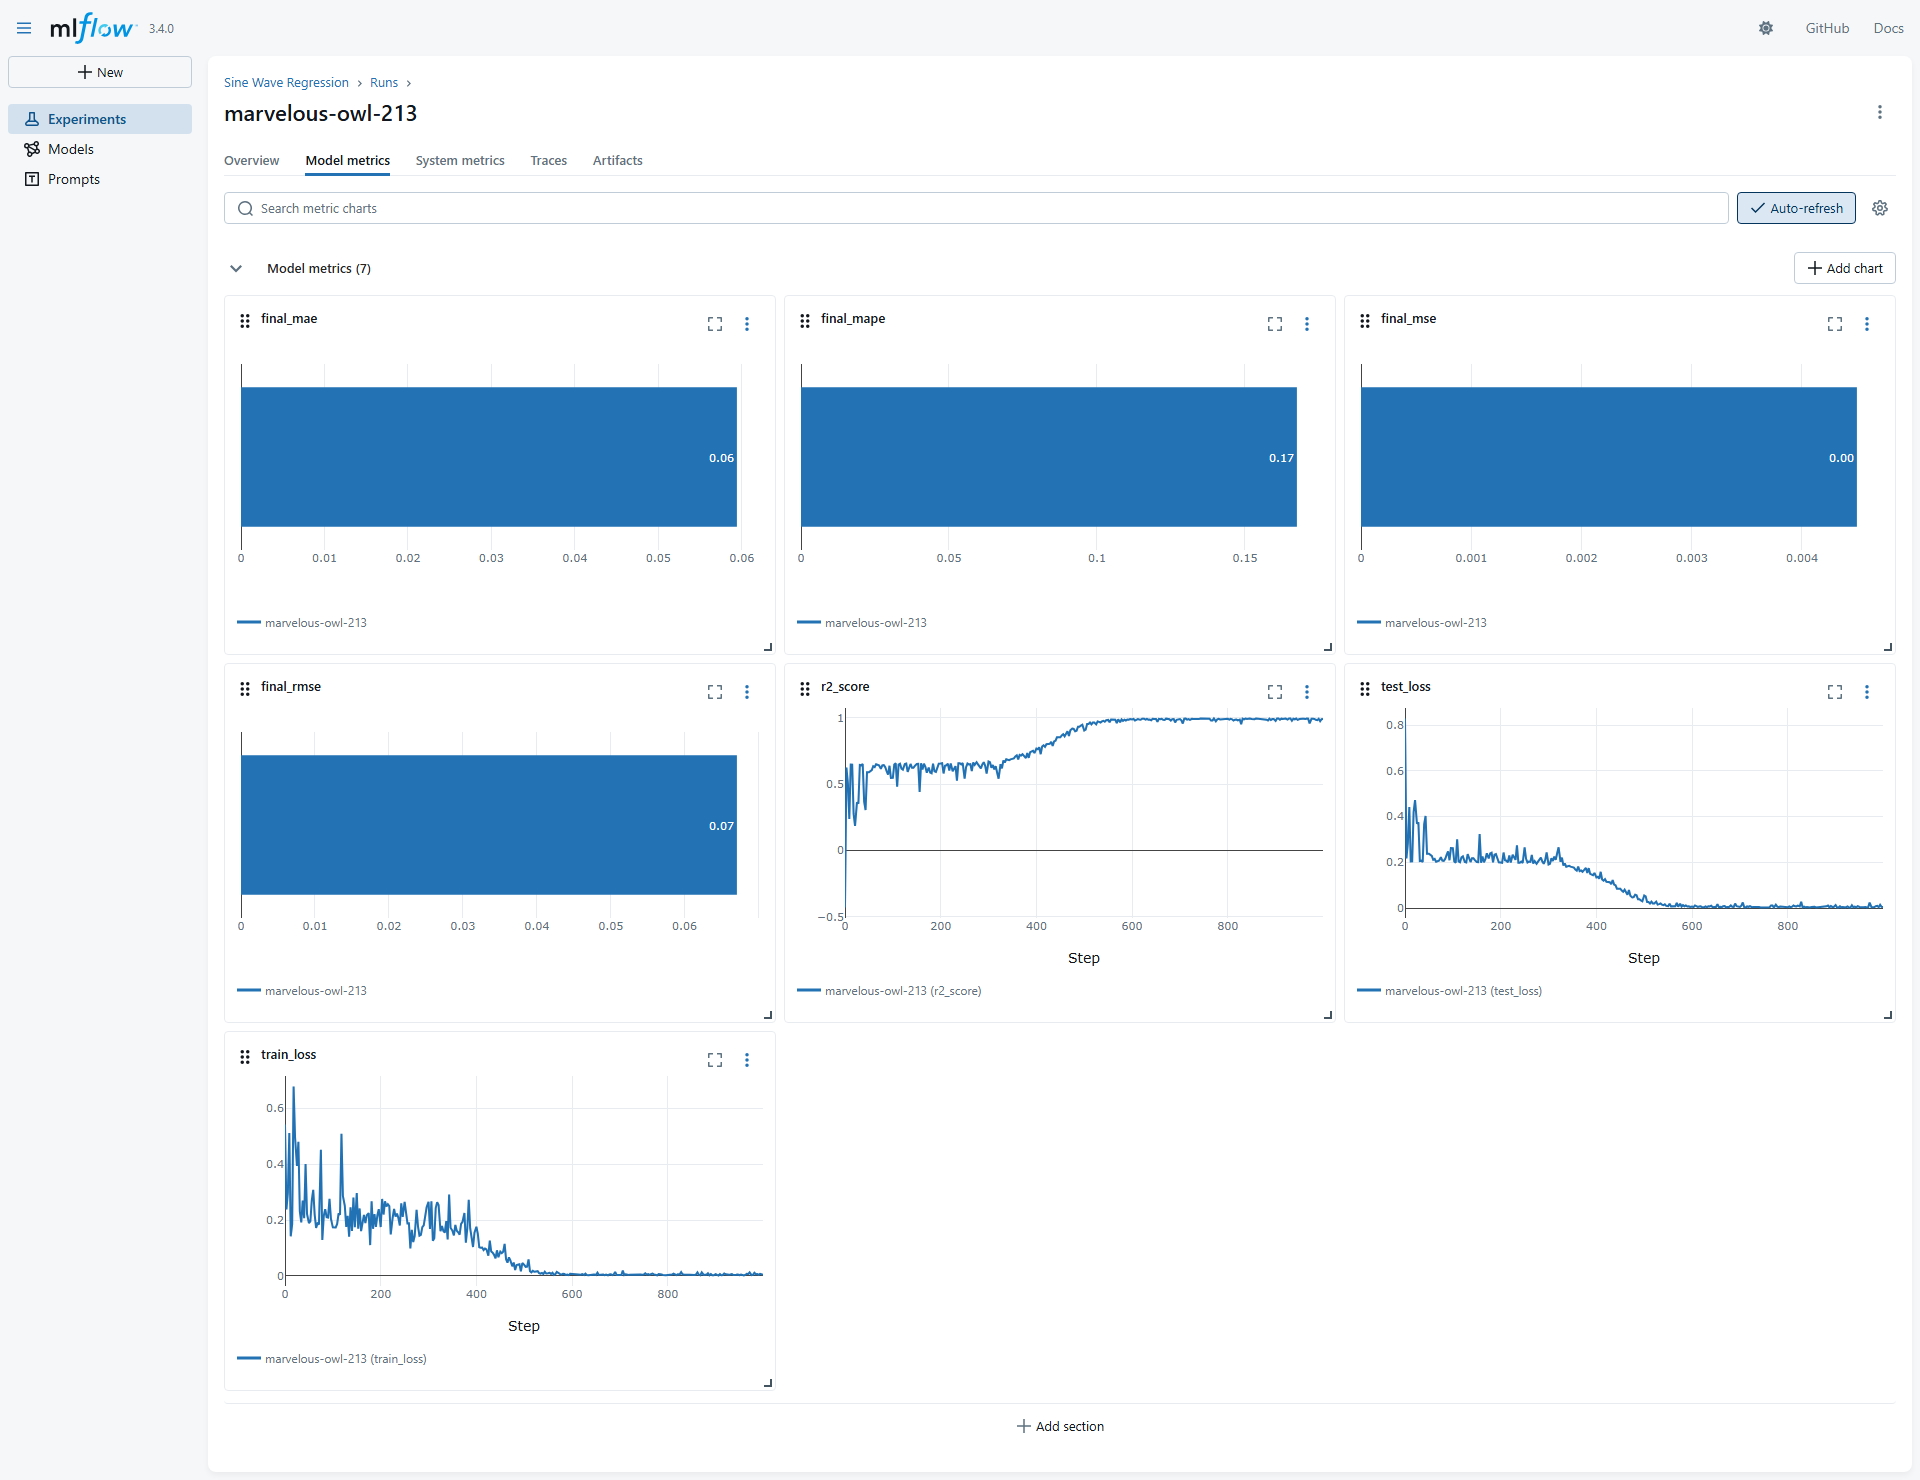

In [50]:
params = {
    "input_dim": X.shape[1],
    "output_dim": 1,
    "hidden_dim": 50,
    "learning_rate": 0.07,
    "epochs": 1000,
    "batch_size": 16
}

run_url = train_and_log_model(params)

<p class="task" id="2"></p>

2\. Решите задачу классификации, используя для мониторинга процесса обучения `mlflow`. 

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики `Accuracy` по эпохам. После завершения обучения рассчитайте значение метрик Accuracy, Precision, Recall и F1 и сохраните при помощи `log_metric`. Сохраните обученную модель при помощи `mlflow.pytorch.log_model`. 

Отследите все запуски при помощи `mlflow` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели.


- [ ] Проверено на семинаре

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

<p class="task" id="3"></p>

3\. Повторите задачу 2, вычислив и визуализировав матрицу несоответствий (для обучающей и тестовой выборки). Для визуализации постройте тепловую карту при помощи `seaborn`. Сохраните изображения при помощи `log_figure`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

<p class="task" id="4"></p>

4\. Повторите задачу 2, обучив две модели: линейную и нелинейную. Для каждой из моделей сделайте прогноз (по всей выборке) и визуализируйте облако точек (раскрасьте точки в цвета, соответствующие прогнозам модели). Сохраните изображения при помощи `mlflow`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс в виде `wandb.Image`` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

<p class="task" id="5"></p>

5\. Повторите задачу 2, реализовав логику ранней остановки. Для этого разделите данные на три части: обучающую, валидационную и тестовую. Остановите процесс обучения, если целевая метрика (F1) на валидации не увеличивалась в течении последних $k$ ($k$ - гиперпараметр метода) эпох. В момент остановки выведите сообщение с текущим номером эпохи. Сохраните для запуска номер эпохи, на которой процесс обучения был прерван.

Помимо отслеживания метрик на обучающей и тестовой выборке, также отслеживайте метрики на валидационной выборке в процессе обучения. 

Постройте таблицу , в которой содержится информация о:
* признаках объекта;
* правильном ответе;
* прогнозе модели;
* принадлежности к обучающему, валидационному или тестовому множеству.

Сохраните данную таблицу при помощи `log_table`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `mlflow` со всеми нужными визуализациями.

- [ ] Проверено на семинаре
